This validation case reproduces TDS measurements on oxidised W performed by [A. Dunand et al.](https://iopscience.iop.org/article/10.1088/1741-4326/ac583a)

In the experiments, single crystal W samples (2 mm thick) with different O coverages (clean, 0.5 ML of O, 0.75 ML of O) were exposed to the D<sub>2</sub> flux of $\approx 1.52\times10^{18}\,\mathrm{m}^{-2}\mathrm{s}^{-1}$. D<sub>2</sub> exposure lasted for 3000 s followed by the storage phase for 1 h. After that, TDS of samples was performed with 5 K/s ramp up to 800 K.

Following the approach of [E. A. Hodille et al.](https://iopscience.iop.org/article/10.1088/1741-4326/ad2a29), the evolution of the surface concentration, in the present FESTIM model, is assumed to be governed by D adsorption from the gas phase and desorption. The D diffusivity in W is defined by scaling the corresponding value for H ([N. Fernandez et al.](https://www.sciencedirect.com/science/article/pii/S1359645415003043)) by a factor of $1/\sqrt{2}$. Traps are not considered, since the D absorption flux is negligible at room temperature. 

The FESTIM results are compared to the experimental data and the results of MHIMS simulation, both taken from [E.A. Hodille et al 2024 Nucl. Fusion 64 046022](https://iopscience.iop.org/article/10.1088/1741-4326/ad2a29). Experimental data was extracted with [PlotDigitizer](https://plotdigitizer.com/).

# FESTIM model

In [1]:
import festim as F
import fenics as f
import numpy as np
import sympy as sp
from scipy import interpolate
import h_transport_materials as htm

################### PARAMETERS ###################
# Exposure conditions
T0 = 300  # K
ramp = 5  # K/s
t_imp = 3000  # exposure duration, s
t_storage = 3600  # storage time, s
t_TDS = 100  # s
L = 2e-3  # half thickness, m

# W properties
rho_W = 6.3382e28  # W atomic concentration, m^-3
n_IS = 6 * rho_W  # concentration of interstitial sites, m^-3
n_surf_ref = 1.416e19  # concentration of adsorption sites, m^-2
nu0 = 1e13  # attempt frequency, s^-1

D_H = htm.diffusivities.filter(material=htm.Tungsten, author="fernandez")[0]
D0 = D_H.pre_exp.magnitude / np.sqrt(2)  # diffusivity pre-factor, m^2 s^-1
E_diff = D_H.act_energy.magnitude  # diffusion activation energy, eV

# Transitions
E_bs = E_diff  # energy barrier from bulk to surface, eV
E_diss = 0  # energy barrier for D2 dissociation, eV
Q_sol = 1  # heat of solution, eV


def S0(T):
    # the capturing coefficient
    return f.exp(-E_diss / F.k_B / T)


def K_bs(T, surf_conc, t):
    return nu0 * f.exp(-E_bs / F.k_B / T)


################### MODEL ###################


def run_sim(n_surf, E0, dE, theta_D0, dtheta_D, alpha, beta):
    lamda_des = 1 / np.sqrt(n_surf)  # average distance between adsorption sites, m
    lambda_abs = n_surf / n_IS  # distance between subsurface IS and adsorption sites, m

    def E_des(surf_conc):
        theta_D = surf_conc / n_surf
        E_FD = E0 + dE / (1 + f.exp((theta_D - theta_D0) / dtheta_D))
        E_des = E_FD * (1 - alpha * f.exp(-beta * (1 - theta_D)))
        return E_des

    def E_sb(surf_conc):
        # energy barrier from surface to bulk, eV
        return (E_des(surf_conc) - E_diss) / 2 + E_bs + Q_sol

    def K_sb(T, surf_conc, t):
        return nu0 * f.exp(-E_sb(surf_conc) / F.k_B / T)

    def J_vs(T, surf_conc, t):
        J_ads = (
            2
            * S0(T)
            * (1 - surf_conc / n_surf) ** 2
            * f.conditional(t <= t_imp, 1.52e18, 0)
        )

        J_des = (
            2
            * nu0
            * (lamda_des * surf_conc) ** 2
            * f.exp(-E_des(surf_conc) / F.k_B / T)
        )
        return J_ads - J_des

    W_model = F.Simulation(log_level=40)

    # Mesh
    vertices = np.linspace(0, L, num=500)
    W_model.mesh = F.MeshFromVertices(vertices)

    # Materials
    tungsten = F.Material(id=1, D_0=D0, E_D=E_diff)
    W_model.materials = tungsten

    W_model.T = F.Temperature(
        value=sp.Piecewise(
            (T0, F.t < t_imp + t_storage), (T0 + ramp * (F.t - t_imp - t_storage), True)
        )
    )

    my_BC = F.SurfaceKinetics(
        k_sb=K_sb,
        k_bs=K_bs,
        lambda_IS=lambda_abs,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        t=F.t,
    )

    W_model.boundary_conditions = [my_BC, F.DirichletBC(field=0, value=0, surfaces=2)]

    W_model.dt = F.Stepsize(
        initial_value=1e-7,
        stepsize_change_ratio=1.25,
        max_stepsize=lambda t: 10 if t < t_imp + t_storage + 1 else 0.05,
        dt_min=1e-9,
    )

    W_model.settings = F.Settings(
        absolute_tolerance=1e5,
        relative_tolerance=1e-11,
        maximum_iterations=50,
        final_time=t_imp + t_storage + t_TDS,
    )

    # Exports
    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1), F.TotalSurface(field="T", surface=1)],
        show_units=True,
    )

    W_model.exports = [derived_quantities]

    W_model.initialise()
    W_model.run()

    return derived_quantities


# Fitting parameters from the paper
cases = ["clean", "0.50ML of O", "0.75ML of O"]
inputs = {
    "n_surf": [n_surf_ref, n_surf_ref * (1 - 0.5), n_surf_ref * (1 - 0.75)],
    "E0": [1.142, 1.111, 1.066],
    "dE": [0.346, 0.289, 0.234],
    "theta_D0": [0.253, 0.113, 0.161],
    "dtheta_D": [0.180, 0.082, 0.057],
    "alpha": [0.303, 0.460, 0.437],
    "beta": [8.902, 7.240, 4.144],
}

results = {}
for i, case in enumerate(cases):
    results[case] = run_sim(*[inputs[key][i] for key in inputs.keys()])

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        6.7e+03 s    Elapsed time so far: 27.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        6.7e+03 s    Elapsed time so far: 28.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        6.7e+03 s    Elapsed time so far: 27.7 s


# Comparison with experimental data

The results produced by FESTIM are in good agreement with the experimental data at different O coverages.

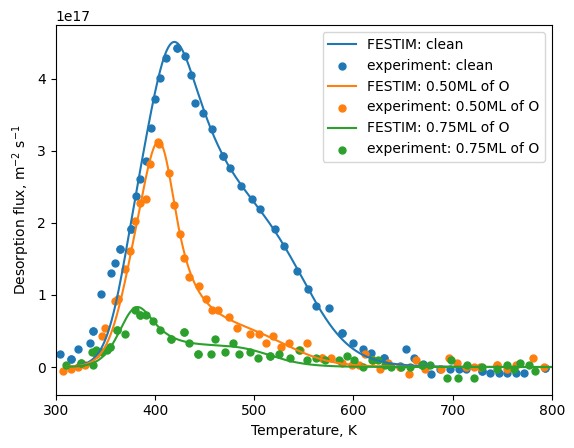

In [2]:
import matplotlib.pyplot as plt


def E_des_pp(surf_conc, n_surf, E0, dE, theta_D0, dtheta_D, alpha, beta):
    theta_D = surf_conc / n_surf
    E_FD = E0 + dE / (1 + np.exp((theta_D - theta_D0) / dtheta_D))
    E_des = E_FD * (1 - alpha * np.exp(-beta * (1 - theta_D)))
    return E_des


def compute_TDS(i, case):
    time = np.array(results[case].t)
    surf_conc = np.array(results[case][0].data)[np.where(time > t_imp + t_storage)]
    T = np.array(results[case][1].data)[np.where(time > t_imp + t_storage)]
    lamda_des = 1 / np.sqrt(inputs["n_surf"][i])

    Flux = (
        2
        * nu0
        * (lamda_des * surf_conc) ** 2
        * np.exp(
            -E_des_pp(surf_conc, *[inputs[key][i] for key in inputs.keys()]) / F.k_B / T
        )
    )

    return T, Flux


ref_labels = ["clean", "050OML", "075OML"]

for i, case in enumerate(cases):

    T, Flux = compute_TDS(i, case)

    (l1,) = plt.plot(
        T,
        Flux,
        label="FESTIM: " + case,
    )

    exp_data = np.loadtxt(
        f"./reference_data/{ref_labels[i]}_exp.csv", skiprows=1, delimiter=","
    )
    plt.scatter(
        exp_data[:, 0],
        exp_data[:, 1],
        marker="o",
        s=25,
        color=l1.get_color(),
        label="experiment: " + case,
    )

plt.ylabel(r"Desorption flux, m$^{-2}$ s$^{-1}$")
plt.xlabel("Temperature, K")
plt.legend()
plt.xlim(300, 800)
plt.show()

# Comparison with MHIMS

The FESTIM results correlate perfectly with the MHIMS data.

Max. relative error clean: 2.34%
Max. relative error 0.50ML of O: 0.88%
Max. relative error 0.75ML of O: 0.96%


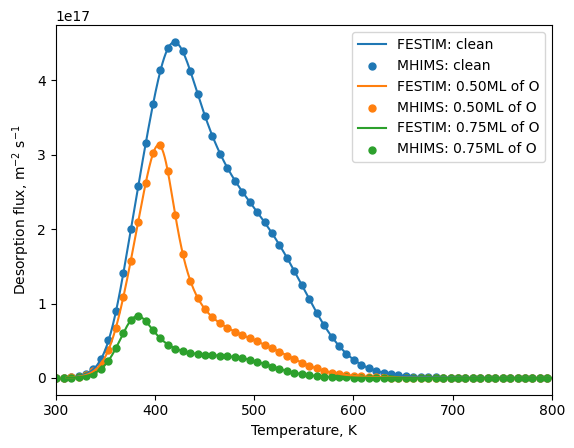

In [3]:
def norm(c_comp, c_ex):
    return max(np.abs(c_comp - c_ex) / c_comp * 100)


for i, case in enumerate(cases):

    T, Flux = compute_TDS(i, case)

    (l1,) = plt.plot(
        T,
        Flux,
        label="FESTIM: " + case,
    )

    MHIMS_data = np.loadtxt(
        f"./reference_data/{ref_labels[i]}_MHIMS.txt", skiprows=1, delimiter=","
    )
    plt.scatter(
        MHIMS_data[::15, 0],
        MHIMS_data[::15, 1],
        marker="o",
        s=25,
        color=l1.get_color(),
        label="MHIMS: " + case,
    )

    MHIMS_interp = interpolate.interp1d(MHIMS_data[:, 0], MHIMS_data[:, 1])
    print(f"Max. relative error {case}: {norm(MHIMS_interp(T), Flux):.2f}%")


plt.ylabel(r"Desorption flux, m$^{-2}$ s$^{-1}$")
plt.xlabel("Temperature, K")
plt.legend()
plt.xlim(300, 800)
plt.show()

# Paper-quality figure

/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/pypalettes/utils.py:5: DeprecationWarning: open_binary is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_binary('pypalettes', path) as f:


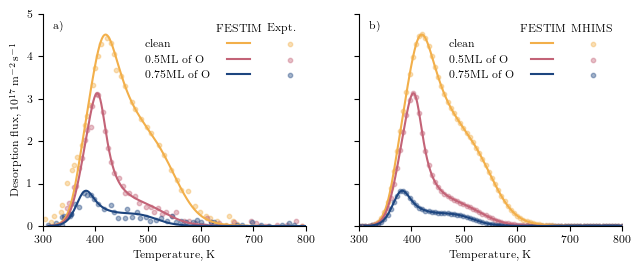

In [48]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from string import ascii_lowercase
from pypalettes import load_cmap

cmap = load_cmap("Sunset2", reverse=True)

params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{bm}",
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
        ]
    ),
    "font.size": 8,
    "font.family": "Times New Roman",
}
plt.rcParams.update(params)

mm2inch = 0.1 / 2.54
fig, axs = plt.subplots(1, 2, figsize=(190 * mm2inch, 70 * mm2inch), sharey=True)


def E_des_pp(surf_conc, n_surf, E0, dE, theta_D0, dtheta_D, alpha, beta):
    theta_D = surf_conc / n_surf
    E_FD = E0 + dE / (1 + np.exp((theta_D - theta_D0) / dtheta_D))
    E_des = E_FD * (1 - alpha * np.exp(-beta * (1 - theta_D)))
    return E_des


def compute_TDS(i, case):
    time = np.array(results[case].t)
    surf_conc = np.array(results[case][0].data)[np.where(time > t_imp + t_storage)]
    T = np.array(results[case][1].data)[np.where(time > t_imp + t_storage)]
    lamda_des = 1 / np.sqrt(inputs["n_surf"][i])

    Flux = (
        2
        * nu0
        * (lamda_des * surf_conc) ** 2
        * np.exp(
            -E_des_pp(surf_conc, *[inputs[key][i] for key in inputs.keys()]) / F.k_B / T
        )
    )

    return T, Flux


ref_labels = ["clean", "050OML", "075OML"]

for i, case in enumerate(cases):

    T, Flux = compute_TDS(i, case)
    exp_data = np.loadtxt(
        f"./reference_data/{ref_labels[i]}_exp.csv", skiprows=1, delimiter=","
    )
    MHIMS_data = np.loadtxt(
        f"./reference_data/{ref_labels[i]}_MHIMS.txt", skiprows=1, delimiter=","
    )

    (l1,) = axs[0].plot(T, Flux / 1e17, label="None", color=cmap(2 * i), lw=1.5)

    axs[1].plot(T, Flux / 1e17, label="None", color=l1.get_color(), lw=1.5)

    axs[0].scatter(
        exp_data[:, 0],
        exp_data[:, 1] / 1e17,
        marker="o",
        s=10,
        color=l1.get_color(),
        alpha=0.4,
        label="None",
    )

    axs[1].scatter(
        MHIMS_data[::12, 0],
        MHIMS_data[::12, 1] / 1e17,
        marker="o",
        s=10,
        color=l1.get_color(),
        alpha=0.4,
        label="None",
    )

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor="none", linewidth=0)

empty_label = [""]
label_col1 = ["", "clean", "0.5ML of O", "0.75ML of O"]
label_col2 = ["FESTIM"]
label_col3 = ["Expt.", "MHIMS"]

for i, axis in enumerate(axs):
    h, l = axis.get_legend_handles_labels()
    handles = [extra] * 5 + h[0::2] + [extra] + h[1::2]
    labels = np.concatenate(
        [label_col1, label_col2, empty_label * 3, [label_col3[i]], empty_label * 3]
    )
    axis.set_xlabel("Temperature, K")
    axis.set_xlim(300, 800)
    axis.text(320, 4.7, f"{ascii_lowercase[i]})", ha="left", va="center")
    axis.legend(
        handles,
        labels,
        fancybox=False,
        ncols=3,
        handletextpad=-3,
        frameon=False,
        columnspacing=1.5,
    )
    axis.spines[["right", "top"]].set_visible(False)
    axis.set_ylim(0, 5)

axs[0].set_ylabel(r"Desorption flux, $10^{17}\,\si{m^{-2}.s{^{-1}}}$")

# plt.savefig("./D_WO.png", dpi=1000, bbox_inches="tight", pad_inches=0.01)
plt.show()